In [1]:
# Twitter Sentiment Analysis Experiment
# Comprehensive analysis using TextBlob, VADER, and Transformers

In [3]:
# ==================== INSTALLATION REQUIREMENTS ====================
# Install required packages:
# !pip install tweepy textblob vaderSentiment transformers pandas matplotlib seaborn nltk torch
# !python -m textblob.download_corpora

In [4]:
# ==================== IMPORTS ====================
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import re
import warnings
import nltk
from datetime import datetime, timedelta
import time

In [5]:
# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    pass

warnings.filterwarnings('ignore')

In [6]:
# ==================== CONFIGURATION ====================
class TwitterConfig:
    def __init__(self):
        # Twitter API credentials (replace with your actual credentials)
        self.API_KEY = "your_api_key_here"
        self.API_SECRET = "your_api_secret_here"
        self.ACCESS_TOKEN = "your_access_token_here"
        self.ACCESS_TOKEN_SECRET = "your_access_token_secret_here"
        self.BEARER_TOKEN = "your_bearer_token_here"

In [7]:
# ==================== DATA PREPROCESSING ====================
class TextPreprocessor:
    @staticmethod
    def clean_tweet(text):
        """Clean tweet text for analysis"""
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove special characters but keep emoticons
        text = re.sub(r'[^a-zA-Z0-9\s!?.:;,()\'\"😀-🙏]', '', text)
        return text

In [8]:
# ==================== TWITTER DATA COLLECTOR ====================
class TwitterCollector:
    def __init__(self, config):
        self.config = config
        self.api = None
        self.client = None

    def setup_api(self):
        """Setup Twitter API connection"""
        try:
            # Setup API v1.1 for tweepy
            auth = tweepy.OAuthHandler(self.config.API_KEY, self.config.API_SECRET)
            auth.set_access_token(self.config.ACCESS_TOKEN, self.config.ACCESS_TOKEN_SECRET)
            self.api = tweepy.API(auth, wait_on_rate_limit=True)

            # Setup API v2
            self.client = tweepy.Client(
                bearer_token=self.config.BEARER_TOKEN,
                consumer_key=self.config.API_KEY,
                consumer_secret=self.config.API_SECRET,
                access_token=self.config.ACCESS_TOKEN,
                access_token_secret=self.config.ACCESS_TOKEN_SECRET,
                wait_on_rate_limit=True
            )

            print("✅ Twitter API connection established successfully!")
            return True

        except Exception as e:
            print(f"❌ Twitter API connection failed: {e}")
            print("📝 Note: Using sample data for demonstration")
            return False

    def collect_tweets(self, query, count=100, lang='en'):
        """Collect tweets using Twitter API or return sample data"""
        if self.api is None:
            return self.get_sample_tweets()

        tweets = []
        try:
            # Use API v2 for better results
            tweets_data = tweepy.Paginator(
                self.client.search_recent_tweets,
                query=query,
                tweet_fields=['created_at', 'author_id', 'public_metrics'],
                max_results=min(100, count),
                limit=max(1, count//100)
            ).flatten(limit=count)

            for tweet in tweets_data:
                tweets.append({
                    'id': tweet.id,
                    'text': tweet.text,
                    'created_at': tweet.created_at,
                    'author_id': tweet.author_id,
                    'retweet_count': tweet.public_metrics['retweet_count'],
                    'like_count': tweet.public_metrics['like_count']
                })

        except Exception as e:
            print(f"⚠️ Error collecting tweets: {e}")
            return self.get_sample_tweets()

        return tweets

    def get_sample_tweets(self):
        """Return sample tweets for demonstration when API is not available"""
        sample_tweets = [
            "I absolutely love this new product! It's amazing! 😍",
            "This is terrible. Worst experience ever. Very disappointed.",
            "The weather is okay today. Nothing special.",
            "Best day ever! So happy and grateful! 🎉",
            "I hate waiting in long queues. So frustrating!",
            "The movie was decent. Not great, not bad either.",
            "Incredible service! Highly recommend to everyone!",
            "Poor quality. Would not buy again. Waste of money.",
            "It's an average product. Does what it's supposed to do.",
            "Outstanding performance! Exceeded all expectations!",
            "Disappointing results. Expected much better quality.",
            "Neutral opinion. Could be better, could be worse.",
            "Fantastic experience! Will definitely come back!",
            "Horrible customer service. Very rude staff.",
            "The food was okay. Standard restaurant experience.",
            "Amazing! This completely changed my life! ✨",
            "Worst purchase I've ever made. Total regret.",
            "It's fine. Nothing to complain about really.",
            "Excellent quality! Perfect for my needs! 👍",
            "Bad experience. Will not recommend to others."
        ]

        tweets = []
        for i, text in enumerate(sample_tweets):
            tweets.append({
                'id': f'sample_{i+1}',
                'text': text,
                'created_at': datetime.now() - timedelta(hours=i),
                'author_id': f'user_{i+1}',
                'retweet_count': np.random.randint(0, 100),
                'like_count': np.random.randint(0, 500)
            })

        return tweets

In [9]:
# ==================== SENTIMENT ANALYZERS ====================
class SentimentAnalyzer:
    def __init__(self):
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.transformer_pipeline = None
        self.setup_transformer()

    def setup_transformer(self):
        """Setup Hugging Face transformer pipeline"""
        try:
            # Use a lightweight model for sentiment analysis
            model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
            self.transformer_pipeline = pipeline(
                "sentiment-analysis",
                model=model_name,
                tokenizer=model_name,
                max_length=512,
                truncation=True
            )
            print("✅ Transformer model loaded successfully!")
        except Exception as e:
            print(f"⚠️ Transformer model loading failed: {e}")
            # Fallback to simpler model
            try:
                self.transformer_pipeline = pipeline("sentiment-analysis")
                print("✅ Fallback transformer model loaded!")
            except:
                print("❌ No transformer model available")

    def textblob_sentiment(self, text):
        """Analyze sentiment using TextBlob"""
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        if polarity > 0.1:
            sentiment = 'Positive'
        elif polarity < -0.1:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return {
            'sentiment': sentiment,
            'polarity': polarity,
            'subjectivity': subjectivity,
            'confidence': abs(polarity)
        }

    def vader_sentiment(self, text):
        """Analyze sentiment using VADER"""
        scores = self.vader_analyzer.polarity_scores(text)
        compound = scores['compound']

        if compound >= 0.05:
            sentiment = 'Positive'
        elif compound <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return {
            'sentiment': sentiment,
            'compound': compound,
            'positive': scores['pos'],
            'negative': scores['neg'],
            'neutral': scores['neu'],
            'confidence': abs(compound)
        }

    def transformer_sentiment(self, text):
        """Analyze sentiment using Transformers"""
        if self.transformer_pipeline is None:
            return {
                'sentiment': 'Neutral',
                'confidence': 0.5,
                'label': 'NEUTRAL'
            }

        try:
            result = self.transformer_pipeline(text)[0]
            label = result['label'].upper()
            confidence = result['score']

            # Map different label formats to standard format
            if 'POS' in label or label == 'POSITIVE':
                sentiment = 'Positive'
            elif 'NEG' in label or label == 'NEGATIVE':
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'

            return {
                'sentiment': sentiment,
                'confidence': confidence,
                'label': label
            }
        except Exception as e:
            print(f"Transformer analysis error: {e}")
            return {
                'sentiment': 'Neutral',
                'confidence': 0.5,
                'label': 'NEUTRAL'
            }

In [10]:
# ==================== DATA ANALYZER ====================
class SentimentComparator:
    def __init__(self):
        self.results_df = None

    def analyze_tweets(self, tweets):
        """Perform comprehensive sentiment analysis"""
        preprocessor = TextPreprocessor()
        analyzer = SentimentAnalyzer()

        results = []

        print("🔄 Analyzing tweets with multiple models...")
        for i, tweet in enumerate(tweets):
            clean_text = preprocessor.clean_tweet(tweet['text'])

            # Skip empty tweets
            if len(clean_text.strip()) == 0:
                continue

            # TextBlob analysis
            textblob_result = analyzer.textblob_sentiment(clean_text)

            # VADER analysis
            vader_result = analyzer.vader_sentiment(clean_text)

            # Transformer analysis
            transformer_result = analyzer.transformer_sentiment(clean_text)

            results.append({
                'tweet_id': tweet['id'],
                'original_text': tweet['text'],
                'clean_text': clean_text,
                'created_at': tweet['created_at'],
                'retweet_count': tweet.get('retweet_count', 0),
                'like_count': tweet.get('like_count', 0),

                # TextBlob results
                'textblob_sentiment': textblob_result['sentiment'],
                'textblob_polarity': textblob_result['polarity'],
                'textblob_subjectivity': textblob_result['subjectivity'],
                'textblob_confidence': textblob_result['confidence'],

                # VADER results
                'vader_sentiment': vader_result['sentiment'],
                'vader_compound': vader_result['compound'],
                'vader_positive': vader_result['positive'],
                'vader_negative': vader_result['negative'],
                'vader_neutral': vader_result['neutral'],
                'vader_confidence': vader_result['confidence'],

                # Transformer results
                'transformer_sentiment': transformer_result['sentiment'],
                'transformer_confidence': transformer_result['confidence'],
                'transformer_label': transformer_result['label']
            })

            if (i + 1) % 10 == 0:
                print(f"✅ Processed {i + 1} tweets")

        self.results_df = pd.DataFrame(results)
        print(f"📊 Analysis complete! Processed {len(results)} tweets")
        return self.results_df

    def compare_models(self):
        """Compare sentiment analysis results across models"""
        if self.results_df is None:
            print("❌ No results to compare. Run analyze_tweets first.")
            return

        # Calculate agreement between models
        df = self.results_df

        # Agreement statistics
        textblob_vader_agreement = (df['textblob_sentiment'] == df['vader_sentiment']).mean()
        textblob_transformer_agreement = (df['textblob_sentiment'] == df['transformer_sentiment']).mean()
        vader_transformer_agreement = (df['vader_sentiment'] == df['transformer_sentiment']).mean()

        # Overall agreement (all three models agree)
        overall_agreement = (
            (df['textblob_sentiment'] == df['vader_sentiment']) &
            (df['vader_sentiment'] == df['transformer_sentiment'])
        ).mean()

        print("\n📈 MODEL COMPARISON RESULTS")
        print("=" * 50)
        print(f"TextBlob vs VADER Agreement: {textblob_vader_agreement:.2%}")
        print(f"TextBlob vs Transformer Agreement: {textblob_transformer_agreement:.2%}")
        print(f"VADER vs Transformer Agreement: {vader_transformer_agreement:.2%}")
        print(f"All Models Agreement: {overall_agreement:.2%}")

        # Sentiment distribution by model
        print("\n📊 SENTIMENT DISTRIBUTION BY MODEL")
        print("=" * 50)

        for model in ['textblob', 'vader', 'transformer']:
            sentiment_col = f'{model}_sentiment'
            distribution = df[sentiment_col].value_counts(normalize=True)
            print(f"\n{model.upper()}:")
            for sentiment, percentage in distribution.items():
                print(f"  {sentiment}: {percentage:.2%}")

        return {
            'textblob_vader_agreement': textblob_vader_agreement,
            'textblob_transformer_agreement': textblob_transformer_agreement,
            'vader_transformer_agreement': vader_transformer_agreement,
            'overall_agreement': overall_agreement
        }

In [11]:
# ==================== VISUALIZATION ====================
class SentimentVisualizer:
    def __init__(self, results_df):
        self.df = results_df
        plt.style.use('seaborn-v0_8')

    def plot_sentiment_distribution(self):
        """Plot sentiment distribution comparison"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Sentiment Analysis Results Comparison', fontsize=16, fontweight='bold')

        models = ['textblob', 'vader', 'transformer']
        colors = ['skyblue', 'lightcoral', 'lightgreen']

        # Individual model distributions
        for i, model in enumerate(models):
            sentiment_col = f'{model}_sentiment'
            sentiment_counts = self.df[sentiment_col].value_counts()

            ax = axes[i//2, i%2] if i < 2 else axes[1, 0]
            bars = ax.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
            ax.set_title(f'{model.upper()} Sentiment Distribution')
            ax.set_ylabel('Count')

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{int(height)}', ha='center', va='bottom')

        # Combined comparison
        ax = axes[1, 1]
        sentiment_data = []
        for model in models:
            sentiment_col = f'{model}_sentiment'
            for sentiment in ['Positive', 'Negative', 'Neutral']:
                count = (self.df[sentiment_col] == sentiment).sum()
                sentiment_data.append({
                    'Model': model.upper(),
                    'Sentiment': sentiment,
                    'Count': count
                })

        comparison_df = pd.DataFrame(sentiment_data)
        pivot_df = comparison_df.pivot(index='Sentiment', columns='Model', values='Count')
        pivot_df.plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral', 'lightgreen'])
        ax.set_title('Model Comparison')
        ax.set_ylabel('Count')
        ax.legend(title='Model')
        ax.tick_params(axis='x', rotation=0)

        plt.tight_layout()
        plt.show()

    def plot_confidence_analysis(self):
        """Plot confidence score analysis"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Confidence Score Analysis by Model', fontsize=16, fontweight='bold')

        # TextBlob confidence (based on absolute polarity)
        axes[0].hist(self.df['textblob_confidence'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].set_title('TextBlob Confidence\n(Absolute Polarity)')
        axes[0].set_xlabel('Confidence Score')
        axes[0].set_ylabel('Frequency')

        # VADER confidence (based on absolute compound score)
        axes[1].hist(self.df['vader_confidence'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1].set_title('VADER Confidence\n(Absolute Compound Score)')
        axes[1].set_xlabel('Confidence Score')
        axes[1].set_ylabel('Frequency')

        # Transformer confidence
        axes[2].hist(self.df['transformer_confidence'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[2].set_title('Transformer Confidence\n(Model Score)')
        axes[2].set_xlabel('Confidence Score')
        axes[2].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def plot_agreement_heatmap(self):
        """Plot agreement heatmap between models"""
        # Create agreement matrix
        models = ['TextBlob', 'VADER', 'Transformer']
        sentiment_columns = ['textblob_sentiment', 'vader_sentiment', 'transformer_sentiment']

        agreement_matrix = np.zeros((3, 3))

        for i in range(3):
            for j in range(3):
                if i == j:
                    agreement_matrix[i, j] = 1.0
                else:
                    agreement = (self.df[sentiment_columns[i]] == self.df[sentiment_columns[j]]).mean()
                    agreement_matrix[i, j] = agreement

        plt.figure(figsize=(8, 6))
        sns.heatmap(agreement_matrix,
                   annot=True,
                   fmt='.2%',
                   xticklabels=models,
                   yticklabels=models,
                   cmap='Blues',
                   square=True,
                   cbar_kws={'label': 'Agreement Rate'})
        plt.title('Model Agreement Heatmap', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_sentiment_timeline(self):
        """Plot sentiment over time"""
        if 'created_at' not in self.df.columns:
            print("⚠️ No timestamp data available for timeline plot")
            return

        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        fig.suptitle('Sentiment Analysis Over Time', fontsize=16, fontweight='bold')

        models = ['textblob', 'vader', 'transformer']
        colors = ['skyblue', 'lightcoral', 'lightgreen']

        for i, model in enumerate(models):
            sentiment_col = f'{model}_sentiment'

            # Group by time and sentiment
            time_sentiment = self.df.groupby([pd.Grouper(key='created_at', freq='H'), sentiment_col]).size().unstack(fill_value=0)

            if not time_sentiment.empty:
                time_sentiment.plot(kind='bar', stacked=True, ax=axes[i], color=['red', 'gray', 'green'])
                axes[i].set_title(f'{model.upper()} Sentiment Timeline')
                axes[i].set_xlabel('Time')
                axes[i].set_ylabel('Tweet Count')
                axes[i].legend(title='Sentiment')
                axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

In [12]:
# ==================== MAIN EXPERIMENT CLASS ====================
class TwitterSentimentExperiment:
    def __init__(self):
        self.config = TwitterConfig()
        self.collector = TwitterCollector(self.config)
        self.comparator = SentimentComparator()
        self.results_df = None

    def run_experiment(self, query="Python programming", tweet_count=50):
        """Run the complete sentiment analysis experiment"""
        print("🚀 STARTING TWITTER SENTIMENT ANALYSIS EXPERIMENT")
        print("=" * 60)

        # Step 1: Setup API connection
        print("\n📡 Step 1: Setting up Twitter API connection...")
        api_connected = self.collector.setup_api()

        # Step 2: Collect tweets
        print(f"\n📥 Step 2: Collecting tweets about '{query}'...")
        tweets = self.collector.collect_tweets(query, tweet_count)
        print(f"✅ Collected {len(tweets)} tweets")

        # Step 3: Analyze sentiments
        print(f"\n🧠 Step 3: Performing sentiment analysis...")
        self.results_df = self.comparator.analyze_tweets(tweets)

        # Step 4: Compare models
        print(f"\n📊 Step 4: Comparing model performance...")
        comparison_results = self.comparator.compare_models()

        # Step 5: Generate visualizations
        print(f"\n📈 Step 5: Generating visualizations...")
        visualizer = SentimentVisualizer(self.results_df)

        # Display visualizations
        visualizer.plot_sentiment_distribution()
        visualizer.plot_confidence_analysis()
        visualizer.plot_agreement_heatmap()
        visualizer.plot_sentiment_timeline()

        # Step 6: Generate detailed report
        self.generate_report(comparison_results)

        print("\n✅ EXPERIMENT COMPLETED SUCCESSFULLY!")
        return self.results_df

    def generate_report(self, comparison_results):
        """Generate detailed analysis report"""
        print("\n📋 DETAILED ANALYSIS REPORT")
        print("=" * 60)

        df = self.results_df

        # Basic statistics
        print(f"📊 Dataset Overview:")
        print(f"   Total tweets analyzed: {len(df)}")
        print(f"   Average tweet length: {df['clean_text'].str.len().mean():.1f} characters")

        # Model performance summary
        print(f"\n🎯 Model Performance Summary:")
        print(f"   Best agreement pair: VADER vs Transformer ({comparison_results['vader_transformer_agreement']:.2%})")
        print(f"   Overall model consensus: {comparison_results['overall_agreement']:.2%}")

        # Confidence analysis
        print(f"\n🔍 Confidence Analysis:")
        print(f"   TextBlob avg confidence: {df['textblob_confidence'].mean():.3f}")
        print(f"   VADER avg confidence: {df['vader_confidence'].mean():.3f}")
        print(f"   Transformer avg confidence: {df['transformer_confidence'].mean():.3f}")

        # Most confident predictions
        print(f"\n⭐ Most Confident Predictions:")
        high_confidence = df.nlargest(3, 'transformer_confidence')[['clean_text', 'transformer_sentiment', 'transformer_confidence']]
        for idx, row in high_confidence.iterrows():
            print(f"   '{row['clean_text'][:50]}...' → {row['transformer_sentiment']} ({row['transformer_confidence']:.3f})")

        # Disagreement analysis
        disagreements = df[
            (df['textblob_sentiment'] != df['vader_sentiment']) |
            (df['vader_sentiment'] != df['transformer_sentiment']) |
            (df['textblob_sentiment'] != df['transformer_sentiment'])
        ]

        print(f"\n🔥 Disagreement Analysis:")
        print(f"   Tweets with model disagreement: {len(disagreements)} ({len(disagreements)/len(df):.1%})")

        if len(disagreements) > 0:
            print("   Examples of disagreements:")
            for idx, row in disagreements.head(2).iterrows():
                print(f"   '{row['clean_text'][:40]}...'")
                print(f"     TextBlob: {row['textblob_sentiment']}, VADER: {row['vader_sentiment']}, Transformer: {row['transformer_sentiment']}")


🚀 STARTING TWITTER SENTIMENT ANALYSIS EXPERIMENT

📡 Step 1: Setting up Twitter API connection...
✅ Twitter API connection established successfully!

📥 Step 2: Collecting tweets about 'artificial intelligence'...
⚠️ Error collecting tweets: 401 Unauthorized
Unauthorized
✅ Collected 20 tweets

🧠 Step 3: Performing sentiment analysis...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Transformer model loaded successfully!
🔄 Analyzing tweets with multiple models...
✅ Processed 10 tweets
✅ Processed 20 tweets
📊 Analysis complete! Processed 20 tweets

📊 Step 4: Comparing model performance...

📈 MODEL COMPARISON RESULTS
TextBlob vs VADER Agreement: 75.00%
TextBlob vs Transformer Agreement: 85.00%
VADER vs Transformer Agreement: 85.00%
All Models Agreement: 75.00%

📊 SENTIMENT DISTRIBUTION BY MODEL

TEXTBLOB:
  Positive: 50.00%
  Negative: 35.00%
  Neutral: 15.00%

VADER:
  Negative: 50.00%
  Positive: 45.00%
  Neutral: 5.00%

TRANSFORMER:
  Positive: 55.00%
  Negative: 35.00%
  Neutral: 10.00%

📈 Step 5: Generating visualizations...


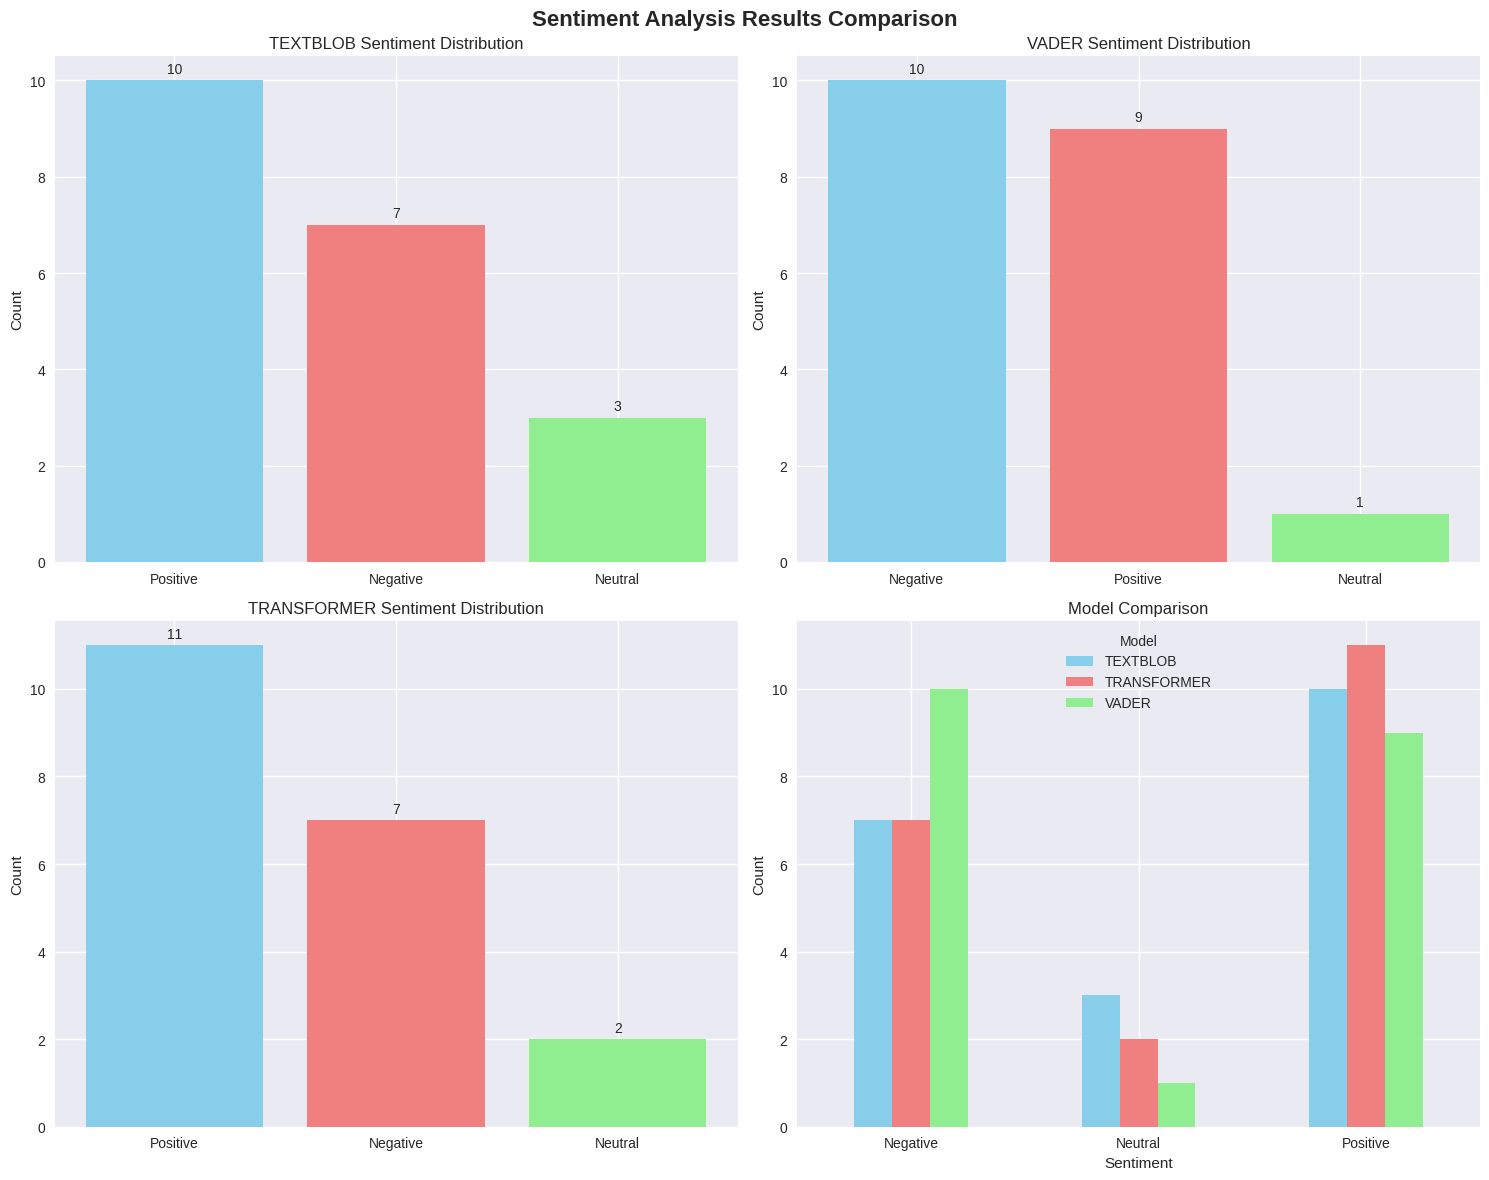

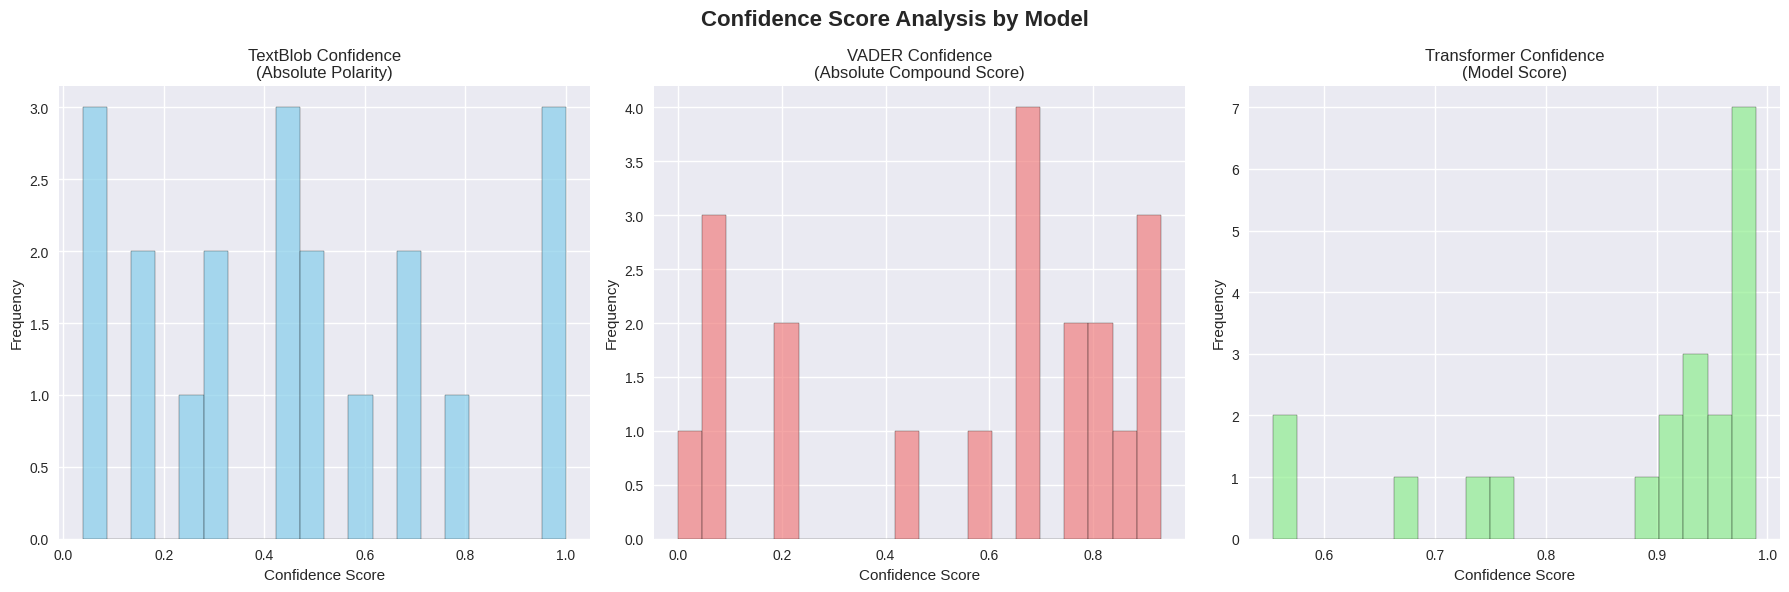

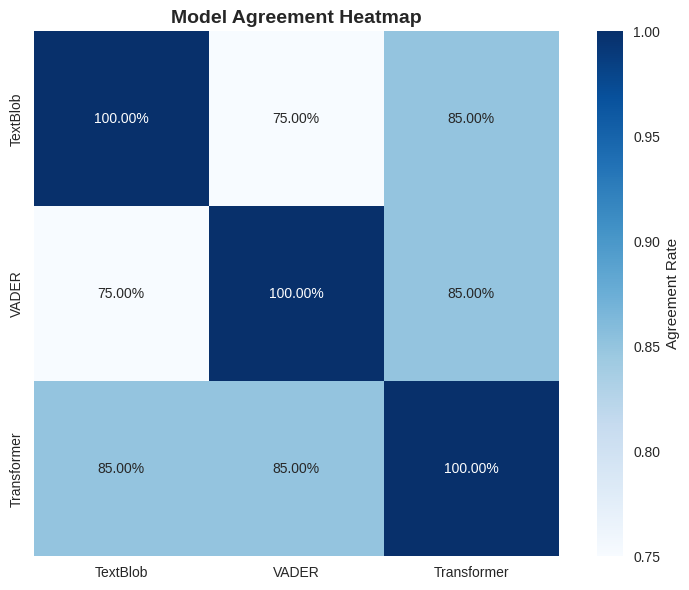

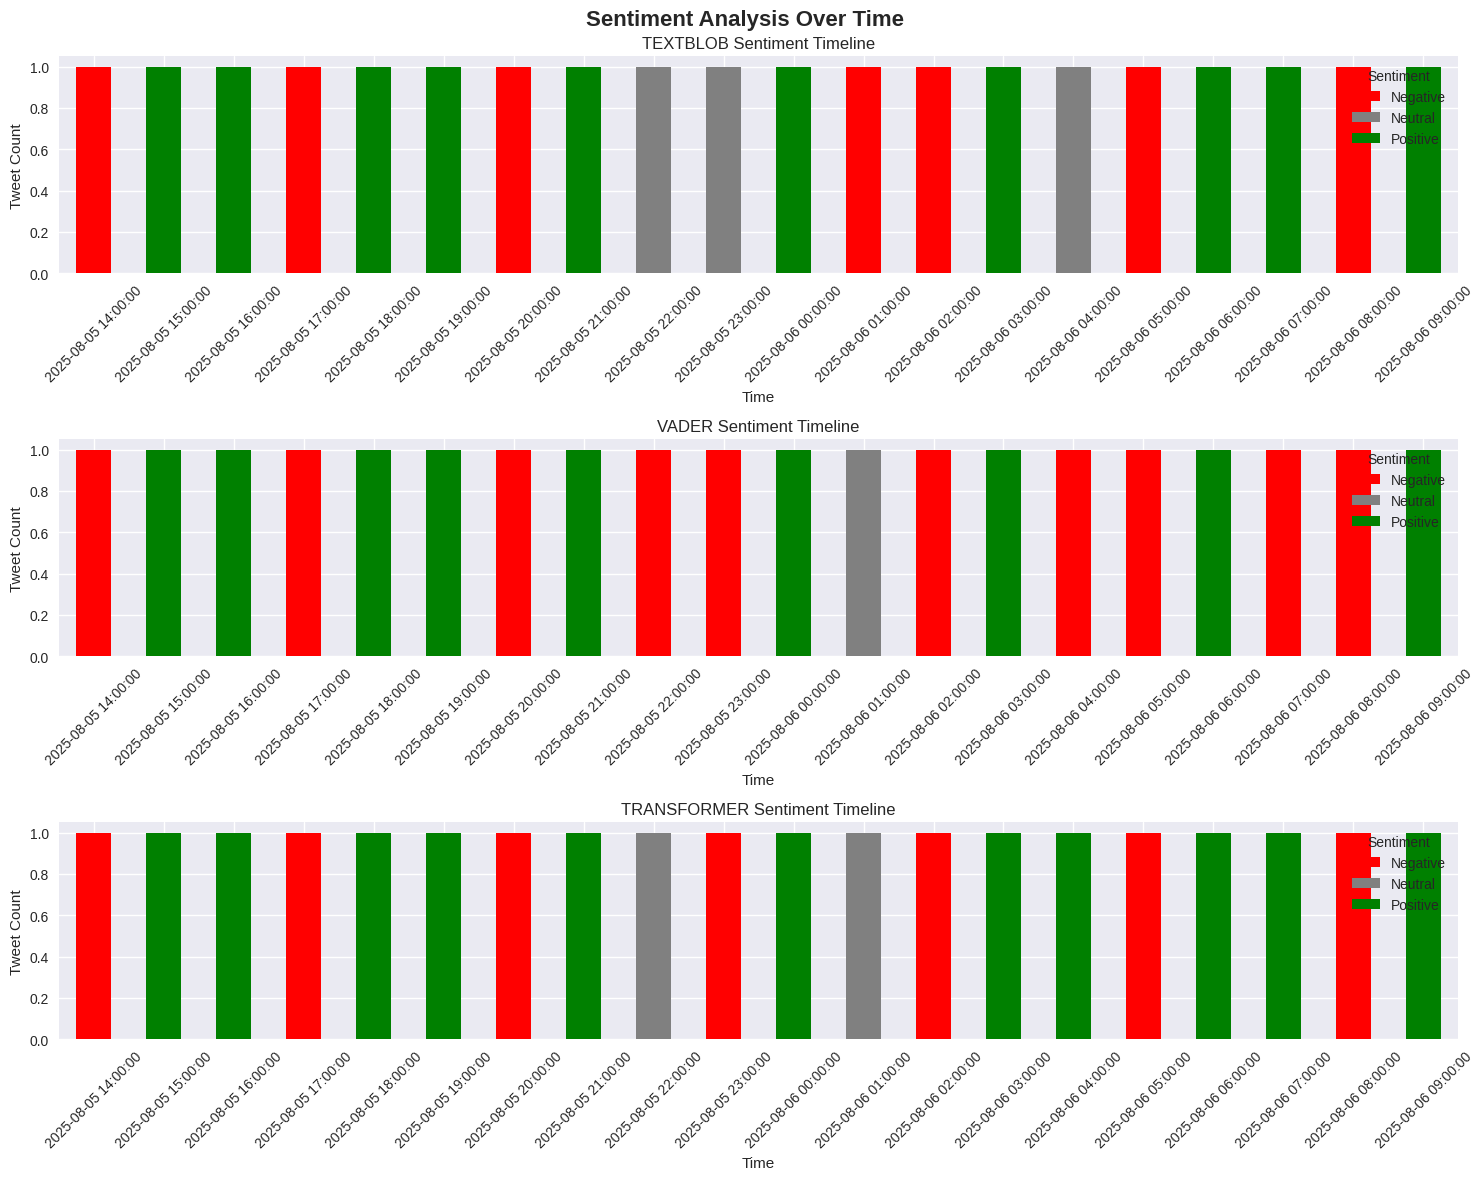


📋 DETAILED ANALYSIS REPORT
📊 Dataset Overview:
   Total tweets analyzed: 20
   Average tweet length: 47.4 characters

🎯 Model Performance Summary:
   Best agreement pair: VADER vs Transformer (85.00%)
   Overall model consensus: 75.00%

🔍 Confidence Analysis:
   TextBlob avg confidence: 0.469
   VADER avg confidence: 0.556
   Transformer avg confidence: 0.880

⭐ Most Confident Predictions:
   'I absolutely love this new product! It's amazing! ...' → Positive (0.989)
   'Fantastic experience! Will definitely come back!...' → Positive (0.987)
   'Best day ever! So happy and grateful! ...' → Positive (0.986)

🔥 Disagreement Analysis:
   Tweets with model disagreement: 5 (25.0%)
   Examples of disagreements:
   'The weather is okay today. Nothing speci...'
     TextBlob: Positive, VADER: Negative, Transformer: Positive
   'The movie was decent. Not great, not bad...'
     TextBlob: Neutral, VADER: Negative, Transformer: Positive

✅ EXPERIMENT COMPLETED SUCCESSFULLY!

💾 Results saved to 't

In [13]:
# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":

    # Run the main experiment
    print("\n" + "="*80)
    experiment = TwitterSentimentExperiment()

    # You can customize these parameters
    SEARCH_QUERY = "artificial intelligence"  # Change this to any topic
    TWEET_COUNT = 50  # Adjust based on your needs

    # Run the complete experiment
    results = experiment.run_experiment(SEARCH_QUERY, TWEET_COUNT)

    # Save results to CSV for further analysis
    if results is not None:
        results.to_csv('twitter_sentiment_analysis_results.csv', index=False)
        print(f"\n💾 Results saved to 'twitter_sentiment_analysis_results.csv'")

    print("\n📝 EXPERIMENT NOTES:")
    print("1. Replace Twitter API credentials in TwitterConfig class")
    print("2. Ensure all required packages are installed")
    print("3. Results are saved to CSV for further analysis")
    print("4. Visualizations show comprehensive model comparison")
    print("5. Sample data is used when API credentials are not available")

# ==================== ADDITIONAL UTILITIES ====================
def analyze_specific_tweet(text):
    """Analyze a specific tweet with all three models"""
    analyzer = SentimentAnalyzer()
    preprocessor = TextPreprocessor()

    clean_text = preprocessor.clean_tweet(text)

    print(f"\n🔍 ANALYZING SPECIFIC TWEET")
    print(f"Original: {text}")
    print(f"Cleaned: {clean_text}")
    print("-" * 50)

    # TextBlob
    tb_result = analyzer.textblob_sentiment(clean_text)
    print(f"TextBlob: {tb_result['sentiment']} (Polarity: {tb_result['polarity']:.3f})")

    # VADER
    vader_result = analyzer.vader_sentiment(clean_text)
    print(f"VADER: {vader_result['sentiment']} (Compound: {vader_result['compound']:.3f})")

    # Transformer
    trans_result = analyzer.transformer_sentiment(clean_text)
    print(f"Transformer: {trans_result['sentiment']} (Confidence: {trans_result['confidence']:.3f})")

# Example usage of specific tweet analysis
# analyze_specific_tweet("I absolutely love this new AI technology! It's revolutionary! 🚀")